In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from torchvision import transforms, datasets
import torchvision.transforms.functional as fn
import torchvision.transforms
import torchmetrics
from PIL import Image

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [77]:
import wandb
WANDB_LOGGING = True
CONFIG = {
    "project_name": "viktor_test_runs",
    "dataloader": {
        "batch_size": 96
    }
}
SWEEP_CONFIG = {
    'method': 'random',
    'name': 'sweep',
    'metric': {
        'goal': 'minimize', 
        'name': 'validation_loss'
        },
    'parameters': {
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [5, 10, 15]},
        'lr': {'max': 0.1, 'min': 0.0001}
    }
}

## Loading and Transforming the Dataset

In this project we are working with images of vegetables and classifying them into 15 distinct classes.

The images were downloaded from: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset. There are 21,000 images in total. The images are already split into 3 sets - training(70%), validation(15%) and testing(15%). However, the percentages (provided on the website) are only rough estimations - in actuality, there are 15,000 training images, and 3000 of each - validation and testing images - which makes it a 71,4285...%, 14,2857...%, 14,2857...% split...

We begin by loading the images from the downloaded repository using the `ImageFolder` object from the `torchvision.datasets` module, immediately giving them transformations defined in the two following blocks of code. First of all, we need to make sure that the images are the same size, so we resize all of them to 224x224 pixels. In addition to that, we augment the training images by doing random rotations and random resized crops (within a range of 80-100% of the original image). 

In [92]:
transform = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
])
train_dataset = ImageFolder('data/Vegetable Images/train', transform=transform)
dataloader = DataLoader(train_dataset, batch_size=CONFIG["dataloader"]["batch_size"], shuffle=True)

In [93]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

mean, std = get_mean_and_std(dataloader)
mean, std

(tensor([0.4476, 0.4421, 0.3217]), tensor([0.2480, 0.2422, 0.2438]))

In [94]:
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [95]:
train_dataset = ImageFolder('data/Vegetable Images/train', transform=train_transform)
val_dataset = ImageFolder('data/Vegetable Images/validation', transform=transform)
test_dataset = ImageFolder('data/Vegetable Images/test', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=CONFIG["dataloader"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=CONFIG["dataloader"]["batch_size"], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=CONFIG["dataloader"]["batch_size"], shuffle=False)

print(f"Number of Training Images: {len(train_dataset)} - Validation Images: {len(val_dataset)} - Test Images: {len(test_dataset)}")
print(f"Number of target classes: {len(train_dataset.classes)}")
print(f"Names of the classes: {(train_dataset.classes)}")

Number of Training Images: 15000 - Validation Images: 3000 - Test Images: 3000
Number of target classes: 15
Names of the classes: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


An example of a training image after augmentation

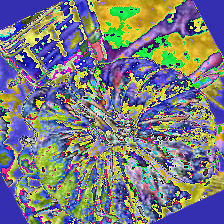

In [96]:
images, labels = next(iter(train_dataloader))
fn.to_pil_image(images[0])

## Defining the Neural Network Architecture

In [82]:
torch.cuda.is_available()

True

In [83]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [84]:
def get_linear_classifier(input_shape: int, output_shape: int, hidden_dim: int = 32):
    return nn.Sequential(
        nn.Linear(in_features=input_shape, out_features=hidden_dim),
        nn.ReLU(),
        nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
        nn.ReLU(),
        nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
        nn.ReLU(),
        nn.Linear(in_features=hidden_dim, out_features=output_shape),
        nn.Softmax()
    )

In [85]:
class VegetableClassifier(nn.Module):
    def __init__(self, network: nn.Sequential, network_out: int, num_classes: int=15) -> None:
        super(VegetableClassifier, self).__init__()
        self.classifier_out = num_classes
        self.device = DEVICE
        self.network = network
        self.avg_maxpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear_classifier = get_linear_classifier(network_out, self.classifier_out)
        
    def forward(self, input):
        input = self.network(input)
        print(input.shape())
        input = self.avg_maxpool(input)
        print(input.shape())
        input = torch.flatten(input, 1)
        print(input.shape())
        return self.linear_classifier(input)
                

In [86]:
network_1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size= (7,7), stride=(2,2), padding=(3,3), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(64),
)

In [87]:
network_2 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size= (7,7), stride=(2,2), padding=(3,3), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
    nn.BatchNorm2d(128),

    nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
    nn.BatchNorm2d(512),
)

In [ ]:
network_3 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size= (7,7), stride=(2,2), padding=(3,3), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

    nn.Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(128),

    nn.Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Conv2d(512, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(512),
)

In [88]:
from tqdm.auto import tqdm  # We use tqdm to display a simple progress bar, allowing us to observe the learning progression.

def get_accuracy(pred, y):
    pred = pred.argmax(dim=1) # Get the largest value for each image - the predicted class
    correct = torch.eq(y, pred).sum().item()
    acc = (correct / len(pred)) 
    return acc

def fit(
  model: nn.Module,
  num_epochs: int,
  loss_fn,
  optimizer: torch.optim.Optimizer,
  train_dataloader: DataLoader,
  val_dataloader: DataLoader,
  print_rate: int = 100
  ):
    accuracy = torchmetrics.Accuracy(num_classes=model.num_classes, average="weighted").to(model.device)
    model = model.to(model.device)
    # Iterate through epochs with tqdm
    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch: {epoch}\n")
        train_loss = 0
        model.train()  # Set mode of model to train
        
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(model.device), y.to(model.device)
            
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss
            
            # Getting the loss gradient and making an optimizer step
            optimizer.zero_grad()  
            loss.backward()
            optimizer.step()

            if batch % print_rate == 0: 
                print(f"Looked at {batch} Batches\t---\t{batch * len(X)}/{len(train_dataloader.dataset)} Samples")
            elif batch == len(train_dataloader) - 1:
                print(f"Looked at {batch} Batches\t---\t{len(train_dataloader.dataset)}/{len(train_dataloader.dataset)} Samples")
        
        # Divide the train_loss by the number of batches to get the average train_loss
        avg_train_loss = train_loss / len(train_dataloader)

        # Validation
        # Setup the Val Loss and Accuracy to accumulate over the batches in the val dataset
        val_loss = 0
        val_acc = 0
        # Set model to evaluation mode and use torch.inference_mode to remove unnecessary training operations 
        model.eval()
        with torch.inference_mode():
            for X_test, y_val in val_dataloader:
                X_test, y_val = X_test.to(model.device), y_val.to(model.device)

                val_pred = model(X_test)
                val_loss += loss_fn(val_pred, y_val)
                val_acc += get_accuracy(pred=val_pred, y=y_val)

        # Get the average Val Loss and Accuracy
        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_acc = val_acc / len(val_dataloader)

        print(f"Train loss: {avg_train_loss} | Val Loss: {avg_val_loss} | Val Accuracy: {avg_val_acc}")
        if WANDB_LOGGING:
            wandb.log({"Train Loss": avg_train_loss,"Val Loss": avg_val_loss, "Val Accuracy": avg_val_acc})

In [89]:
def train():
    model = VegetableClassifier(network=network_3, network_out=512)
    print(f"Total parameters: {sum(param.numel() for param in model.parameters())}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))
    loss_fn = nn.CrossEntropyLoss()
    fit(model=model, num_epochs=10, loss_fn=loss_fn, optimizer=optimizer, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

In [90]:
wandb.init(project=CONFIG['project_name'])
train()
wandb.finish()

Total parameters: 4750991
Trainable parameters: 4750991


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0

Looked at 0 Batches	---	0/15000 Samples
Looked at 100 Batches	---	9600/15000 Samples
Looked at 156 Batches	---	15000/15000 Samples
Train loss: 2.5400493144989014 | Val Loss: 2.5201783180236816 | Val Accuracy: 0.2841796875
Epoch: 1

Looked at 0 Batches	---	0/15000 Samples
Looked at 100 Batches	---	9600/15000 Samples
Looked at 156 Batches	---	15000/15000 Samples
Train loss: 2.3793413639068604 | Val Loss: 2.386030435562134 | Val Accuracy: 0.42610677083333326
Epoch: 2

Looked at 0 Batches	---	0/15000 Samples
Looked at 100 Batches	---	9600/15000 Samples
Looked at 156 Batches	---	15000/15000 Samples
Train loss: 2.2771058082580566 | Val Loss: 2.217670440673828 | Val Accuracy: 0.6038411458333333
Epoch: 3

Looked at 0 Batches	---	0/15000 Samples
Looked at 100 Batches	---	9600/15000 Samples
Looked at 156 Batches	---	15000/15000 Samples
Train loss: 2.207927703857422 | Val Loss: 2.2870728969573975 | Val Accuracy: 0.5279947916666666
Epoch: 4

Looked at 0 Batches	---	0/15000 Samples
Looked

Train Loss,█▆▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Val Accuracy,▁▃▆▅▅▄▆▅▇▃▂▄▇▇█▂█▇▇▇
Val Loss,█▆▃▄▄▅▃▄▂▆▇▅▂▂▁▇▁▂▂▂
Train Loss,2.05936
Val Accuracy,0.66081
Val Loss,2.15504
